In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
for exp in [5, 6, 7, 8, 9, 10]:
    PATH = f'results/NQEClassifier/mnist/{exp}exp/'
    margin_dist = np.load(PATH + 'margin_dist.npy')
    min = np.min(margin_dist)
    max = np.max(margin_dist)
    Q1 = np.percentile(margin_dist, 25)
    Q3 = np.percentile(margin_dist, 75)
    median = np.median(margin_dist)
    margin_boxplot = np.array([min, Q1, median, Q3, max])
    np.save(PATH + 'margin_boxplot2.npy', margin_boxplot)

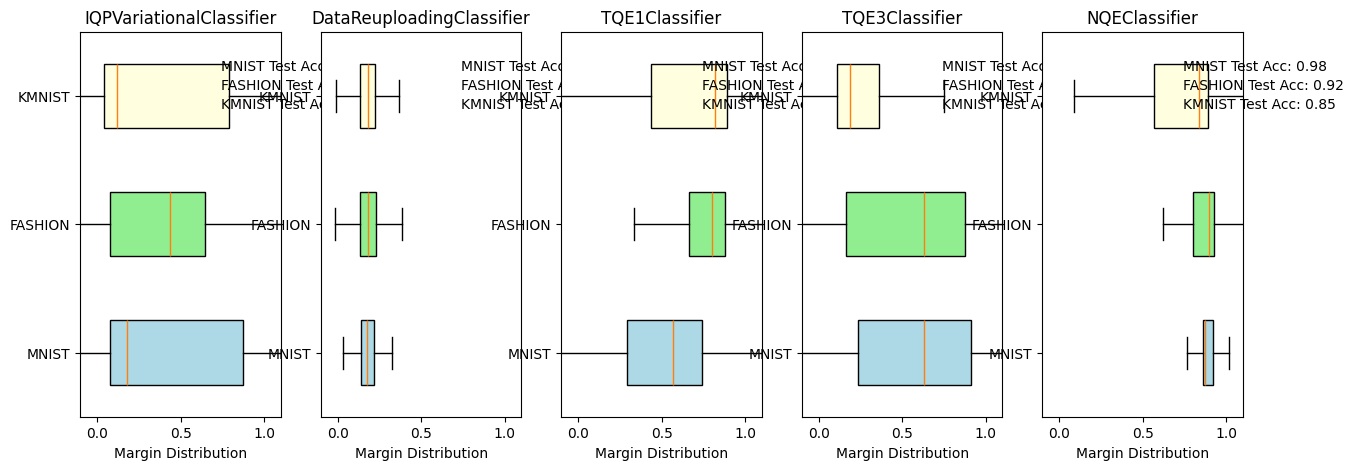

In [3]:
def get_test_accuracy(path):
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "Test Accuracy" in line:
                return float(line.split(":")[1].strip())
    return None

def get_marg_box(exp):
    classifier_list = ["IQPVariationalClassifier", "DataReuploadingClassifier", "TQE1Classifier", "TQE3Classifier", "NQEClassifier"]
    PATH_mnist, PATH_fashion, PATH_kmnist = [], [], []
    for classifier in classifier_list:
        PATH_mnist.append(f"results/{classifier}/mnist/{exp}exp/")
        PATH_fashion.append(f"results/{classifier}/fashion/{exp}exp/")
        PATH_kmnist.append(f"results/{classifier}/kmnist/{exp}exp/")
        
    fig, axes = plt.subplots(1,len(classifier_list), figsize=(15,5))
    position = np.array([0, 1, 2])
    for i in range(len(classifier_list)):
        axes[i].boxplot(np.load(PATH_mnist[i] + "margin_boxplot.npy"), positions=[0], widths=0.5, patch_artist=True, boxprops=dict(facecolor="lightblue"), vert=False, showfliers=False)
        axes[i].boxplot(np.load(PATH_fashion[i] + "margin_boxplot.npy"), positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor="lightgreen"), vert=False, showfliers=False)
        axes[i].boxplot(np.load(PATH_kmnist[i] + "margin_boxplot.npy"), positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor="lightyellow"), vert=False, showfliers=False)
        axes[i].set_xlabel("Margin Distribution")
        axes[i].set_xlim(-0.1, 1.1)
        axes[i].set_yticks([0,1,2], ["MNIST", "FASHION", "KMNIST"])
        axes[i].set_title(f"{classifier_list[i]}")

# Read test accuracies
        mnist_test_acc = get_test_accuracy(PATH_mnist[i] + "results.txt")
        fashion_test_acc = get_test_accuracy(PATH_fashion[i] + "results.txt")
        kmnist_test_acc = get_test_accuracy(PATH_kmnist[i] + "results.txt")

        # Annotate the plot with test accuracies
        axes[i].text(0.7, 0.9, f'MNIST Test Acc: {mnist_test_acc:.2f}', transform=axes[i].transAxes, color='black')
        axes[i].text(0.7, 0.85, f'FASHION Test Acc: {fashion_test_acc:.2f}', transform=axes[i].transAxes, color='black')
        axes[i].text(0.7, 0.8, f'KMNIST Test Acc: {kmnist_test_acc:.2f}', transform=axes[i].transAxes, color='black')
    plt.show()

get_marg_box(1)

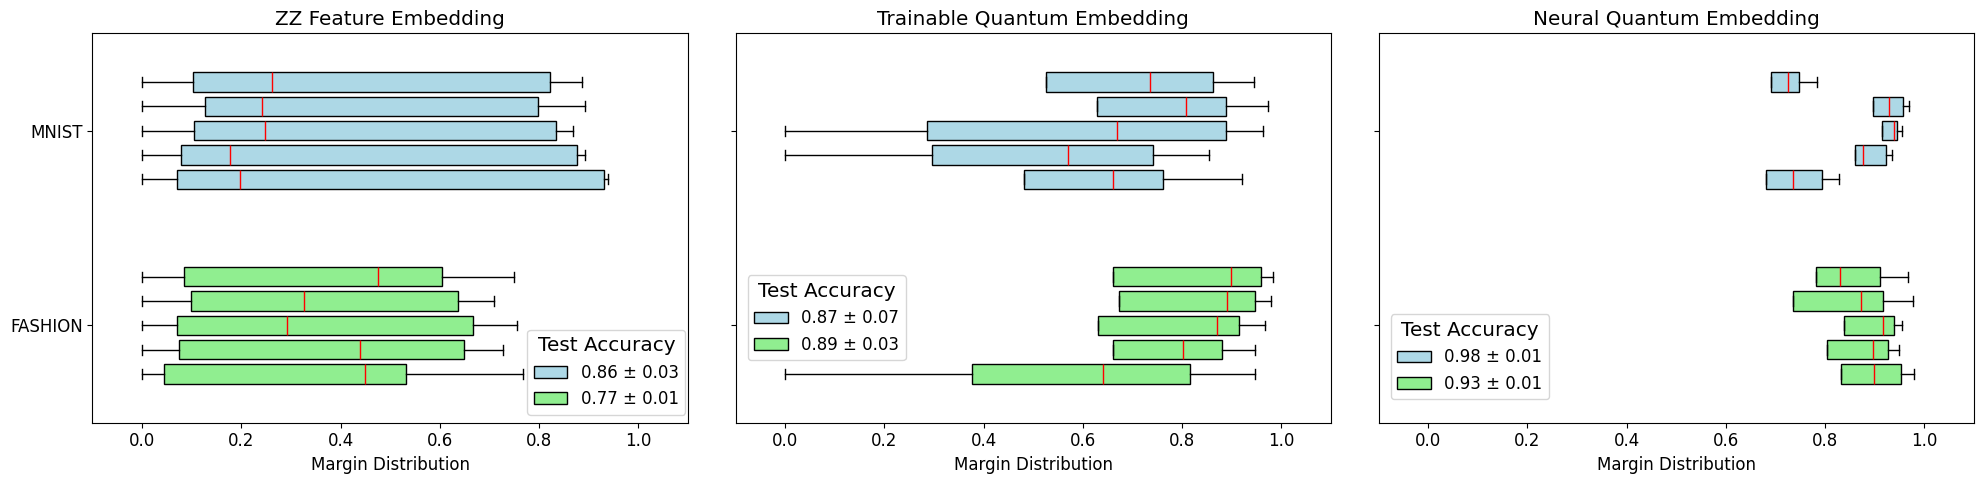

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Rectangle

def get_test_accuracy(path):
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "Test Accuracy" in line:
                return float(line.split(":")[1].strip())
    return None

def get_marg_box():
    plt.rcParams.update({'font.size': 12})
    classifier_list = ["IQPVariationalClassifier", "TQE1Classifier", "NQEClassifier"]
    datasets = ["fashion", "mnist"]
    exp_range = range(5)
    
    fig, axes = plt.subplots(1, len(classifier_list), figsize=(20, 5), sharey=True)
    
    for i, classifier in enumerate(classifier_list):
        all_margin_data = {dataset: [] for dataset in datasets}
        test_accuracies = {dataset: [] for dataset in datasets}
        
        for exp in exp_range:
            for dataset in datasets:
                path = f"results/{classifier}/{dataset}/{exp}exp/"
                margin_data = np.load(path + "margin_boxplot2.npy")
                all_margin_data[dataset].append(margin_data)
                
                test_acc = get_test_accuracy(path + "results.txt")
                test_accuracies[dataset].append(test_acc)
        
        # Plot margin boxplots
        for j, dataset in enumerate(datasets):
            positions = np.arange(exp_range.stop) * 0.25 + j * 2  # Reduce the space between datasets
            for k, margin_data in enumerate(all_margin_data[dataset]):
                axes[i].boxplot(margin_data, positions=[positions[k]], widths=0.2, patch_artist=True, 
                                boxprops=dict(facecolor=["lightgreen", "lightblue"][j], edgecolor='black'), 
                                medianprops=dict(color='red'),  # Set median marker color to red
                                vert=False, showfliers=False)
        
        # Calculate mean and standard deviation of test accuracies
        mean_std_test_acc = {dataset: (np.mean(test_accuracies[dataset]), np.std(test_accuracies[dataset])) for dataset in datasets}
        
        # Create legend entries with rectangular box markers and black outlines
        legend_elements = []
        for j, dataset in enumerate(datasets):
            mean_acc, std_acc = mean_std_test_acc[dataset]
            legend_elements.append(
                Rectangle((0, 0), 1, 0.5, facecolor=["lightgreen", "lightblue"][j], edgecolor='black', label=f'{mean_acc:.2f} ± {std_acc:.2f}', linewidth=1)
            )
        
        # Reverse the order of legend elements
        legend_elements = legend_elements[::-1]
        
        axes[i].set_xlabel("Margin Distribution")
        axes[i].set_xlim(-0.1, 1.1)
        
        # Remove y-ticks for second and third subplots
        if i > 0:
            axes[i].set_yticks([])
        
        title = ["ZZ Feature Embedding", "Trainable Quantum Embedding", "Neural Quantum Embedding"]
        axes[i].set_title(title[i])
        
        # Add the legend to the subplot with a title
        bbox_to_anchor_list = [(1.01, 0.26), (0.3, 0.4), (0.3, 0.3)]
        legend = axes[i].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=bbox_to_anchor_list[i], title='Test Accuracy')
        plt.setp(legend.get_title(), fontsize='large')
    
    # Set y-ticks for the first subplot only
    axes[0].set_yticks([0.5, 2.5])
    axes[0].set_yticklabels(["FASHION", "MNIST"])
    
    plt.tight_layout()
    plt.savefig("margin_boxplot.pdf")
    plt.show()

get_marg_box()





In [23]:
"""
import numpy as np
import matplotlib.pyplot as plt

def get_marg_hist(exp):
    classifier_list = ["IQPVariationalClassifier", "DataReuploadingClassifier", "NQEClassifier"]
    PATH_mnist, PATH_fashion, PATH_kmnist = [], [], []
    for classifier in classifier_list:
        PATH_mnist.append(f"results/{classifier}/mnist/{exp}exp/")
        PATH_fashion.append(f"results/{classifier}/fashion/{exp}exp/")
        PATH_kmnist.append(f"results/{classifier}/kmnist/{exp}exp/")
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    bin_width = 0.1  # Adjust the bin width if necessary

    for i in range(3):
        mnist_data = np.load(PATH_mnist[i] + "margin_dist.npy")
        fashion_data = np.load(PATH_fashion[i] + "margin_dist.npy")
        kmnist_data = np.load(PATH_kmnist[i] + "margin_dist.npy")

        # Calculate histograms
        mnist_hist, mnist_bins = np.histogram(mnist_data, bins=np.arange(0, 1 + bin_width, bin_width))
        fashion_hist, fashion_bins = np.histogram(fashion_data, bins=np.arange(0, 1 + bin_width, bin_width))
        kmnist_hist, kmnist_bins = np.histogram(kmnist_data, bins=np.arange(0, 1 + bin_width, bin_width))

        # Normalize histograms to get probability distributions
        mnist_hist = mnist_hist / len(mnist_data)
        fashion_hist = fashion_hist / len(fashion_data)
        kmnist_hist = kmnist_hist / len(kmnist_data)

        # Plot histograms
        axes[i].bar(mnist_bins[:-1], mnist_hist, width=bin_width, color='lightblue', alpha=0.7, label='MNIST')
        axes[i].bar(fashion_bins[:-1] + bin_width / 3, fashion_hist, width=bin_width, color='lightgreen', alpha=0.7, label='FASHION')
        axes[i].bar(kmnist_bins[:-1] + 2 * bin_width / 3, kmnist_hist, width=bin_width, color='lightyellow', alpha=0.7, label='KMNIST')

        axes[i].set_xlabel("Margin Distribution")
        axes[i].set_xlim(0, 1)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"{classifier_list[i]}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def get_marg_kde(exp):
    classifier_list = ["IQPVariationalClassifier", "DataReuploadingClassifier", "NQEClassifier"]
    PATH_mnist, PATH_fashion, PATH_kmnist = [], [], []
    for classifier in classifier_list:
        PATH_mnist.append(f"results/{classifier}/mnist/{exp}exp/")
        PATH_fashion.append(f"results/{classifier}/fashion/{exp}exp/")
        PATH_kmnist.append(f"results/{classifier}/kmnist/{exp}exp/")
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        mnist_data = np.load(PATH_mnist[i] + "margin_dist.npy")
        fashion_data = np.load(PATH_fashion[i] + "margin_dist.npy")
        kmnist_data = np.load(PATH_kmnist[i] + "margin_dist.npy")

        # Perform KDE
        mnist_kde = gaussian_kde(mnist_data)
        fashion_kde = gaussian_kde(fashion_data)
        kmnist_kde = gaussian_kde(kmnist_data)

        # Define a range for the x-axis
        x = np.linspace(0, 1, 1000)

        # Plot KDEs
        axes[i].plot(x, mnist_kde(x), color='lightblue', label='MNIST')
        axes[i].plot(x, fashion_kde(x), color='lightgreen', label='FASHION')
        axes[i].plot(x, kmnist_kde(x), color='lightyellow', label='KMNIST')

        axes[i].set_xlabel("Margin Distribution")
        axes[i].set_xlim(0, 1)
        axes[i].set_ylabel("Density")
        axes[i].set_title(f"{classifier_list[i]}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()
"""

'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndef get_marg_hist(exp):\n    classifier_list = ["IQPVariationalClassifier", "DataReuploadingClassifier", "NQEClassifier"]\n    PATH_mnist, PATH_fashion, PATH_kmnist = [], [], []\n    for classifier in classifier_list:\n        PATH_mnist.append(f"results/{classifier}/mnist/{exp}exp/")\n        PATH_fashion.append(f"results/{classifier}/fashion/{exp}exp/")\n        PATH_kmnist.append(f"results/{classifier}/kmnist/{exp}exp/")\n        \n    fig, axes = plt.subplots(1, 3, figsize=(15, 5))\n    bin_width = 0.1  # Adjust the bin width if necessary\n\n    for i in range(3):\n        mnist_data = np.load(PATH_mnist[i] + "margin_dist.npy")\n        fashion_data = np.load(PATH_fashion[i] + "margin_dist.npy")\n        kmnist_data = np.load(PATH_kmnist[i] + "margin_dist.npy")\n\n        # Calculate histograms\n        mnist_hist, mnist_bins = np.histogram(mnist_data, bins=np.arange(0, 1 + bin_width, bin_width))\n        fashion_hist, fashi